In [249]:
#needed libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

from xgboost import XGBClassifier, XGBRFClassifier
import category_encoders as ce

In [250]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    '''
    orginial function at : 
    (https://github.com/lindseyberlin/Cat-in-the-Dat-Project/blob/main/notebooks/Lindsey/EDA-Initial-Models.ipynb)
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    
    Inputs:
        estimator: a fit sklearn-style model or pipeline
        X_tr: array or pandas dataframe
            training input variables
        X_te: array or pandas dataframe
            testing input variables
        y_tr: array or pandas series
            training output variable
        y_te: array or pandas series
            testing output variable
        roc_auc: str
            'skip': default, skips calculating roc_auc
            'dec': use decision_function to calculate roc_auc
            'proba': use predict_proba to calculate roc_auc
            
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, values_format='.5g', cmap=plt.cm.Oranges)

In [251]:
# !pip install category_encoders

In [252]:
#pulling our pickled dataframe from EDA notebook
df = pd.read_pickle("../../data/model1.pkl")
df

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,...,10.0,3,2.70,1,0,707.2,300,72.86,75.56,med
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,...,13.7,3,3.70,1,0,611.5,329,55.54,59.24,med-low
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,...,12.2,5,3.29,0,0,527.2,328,59.00,62.29,high
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,...,6.6,7,1.78,2,0,558.2,248,65.02,66.80,med-low
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,...,10.1,3,2.73,3,0,501.9,356,49.36,52.09,med-low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,26.55,215.5,126,...,9.9,6,2.67,2,0,650.8,286,57.43,60.10,low
3329,WV,68,no,no,0,231.1,57,39.29,153.4,55,...,9.6,4,2.59,3,0,575.8,235,60.94,63.53,low
3330,RI,28,no,no,0,180.8,109,30.74,288.8,58,...,14.1,6,3.81,2,0,661.5,258,63.93,67.74,low
3331,CT,184,yes,no,0,213.8,105,36.35,159.6,84,...,5.0,10,1.35,2,0,512.6,326,56.18,57.53,med


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   object 
 3   voice mail plan         3333 non-null   object 
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

## Model-less evaluation

In [254]:
df["churn"].value_counts(normalize=True)

0    0.855086
1    0.144914
Name: churn, dtype: float64

The model would only be right 14.5% of the time if the model only guessed every customer would leave.

As we devlop our models, we will be optomizing the recall score of our models. Our strategies We may identify more people as leaving, but in reality they stay. The company will spend some resources to retain the customer. However, that the cost of keeping them engaged with the company far outweighs the cost of identifying someone as staying and in actuality they leave the company. The company would lose a customer and then have to spend more resources to get a new customer in their place.

## Baseline Model

In [255]:
from sklearn.model_selection import train_test_split

X = df.drop(["churn"], axis = 1)
y= df["churn"]
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.25, random_state=seed)

In [256]:
#describe numerical columns
X_train.describe()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge
count,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000,2249.000000
mean,100.504224,7.865273,179.721521,100.503335,30.553161,200.167808,100.455313,17.014482,200.460516,99.717652,9.020836,10.179013,4.479769,2.748862,1.575811,580.349844,300.676301,56.588479,59.337341
std,39.710542,13.623564,54.312150,20.069965,9.233072,50.594286,20.311670,4.300506,50.549467,19.666704,2.274776,2.805442,2.486380,0.757467,1.314666,90.348058,34.470385,10.454697,10.474121
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,275.200000,188.000000,19.980000,23.250000
25%,73.000000,0.000000,143.700000,87.000000,24.430000,165.700000,87.000000,14.080000,167.600000,86.000000,7.540000,8.400000,3.000000,2.270000,1.000000,519.900000,277.000000,49.520000,52.250000
50%,100.000000,0.000000,178.700000,101.000000,30.380000,200.600000,101.000000,17.050000,200.400000,100.000000,9.020000,10.200000,4.000000,2.750000,1.000000,582.000000,301.000000,56.580000,59.360000
75%,127.000000,17.000000,217.100000,114.000000,36.910000,233.700000,114.000000,19.860000,234.800000,113.000000,10.570000,12.000000,6.000000,3.240000,2.000000,641.800000,324.000000,63.410000,66.340000
max,243.000000,50.000000,346.800000,165.000000,58.960000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,18.400000,19.000000,4.970000,9.000000,871.700000,410.000000,92.560000,96.150000


In [257]:
#no nulls or missing values
X_train.isna().sum()

state                     0
account length            0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
total_domestic_minutes    0
total_domestic_calls      0
total_domestic_charge     0
total_charge              0
churn_rate                0
dtype: int64

In [258]:
#look at object columns
X_train[[c for c in X_train.columns if X_train[c].dtype == 'object']].describe()

,state,international plan,voice mail plan,churn_rate
count,2249,2249,2249,2249
unique,51,2,2,4
top,WV,no,no,med-low
freq,63,2025,1649,747


In [259]:
#looking at churn distribution in training set
y_train.value_counts(normalize=True)

0    0.848822
1    0.151178
Name: churn, dtype: float64

## Logistic Regression

In [260]:
X_train_state = X_train[["state"]]
X_test_state = X_test[["state"]]


ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
state_ohe_train = ohe.fit_transform(X_train_state)
state_ohe_test = ohe.transform(X_test_state)


X_train_state = pd.DataFrame(state_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_state = pd.DataFrame(state_ohe_test, columns=ohe.categories_[0],index= X_test.index)


X_train = pd.concat([X_train, X_train_state], axis=1)
X_test = pd.concat([X_test, X_test_state], axis=1)

X_train = X_train.drop("state", axis = 1)
X_test = X_test.drop("state", axis = 1)

In [261]:
X_train_churn_rate = X_train[["churn_rate"]]
X_test_churn_rate = X_test[["churn_rate"]]

churn_rate_ohe_train = ohe.fit_transform(X_train_churn_rate)
churn_rate_ohe_test = ohe.transform(X_test_churn_rate)

X_train_churn_rate = pd.DataFrame(churn_rate_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_churn_rate = pd.DataFrame(churn_rate_ohe_test, columns=ohe.categories_[0],index= X_test.index)

X_train = pd.concat([X_train, X_train_churn_rate], axis=1)
X_test = pd.concat([X_test, X_test_churn_rate], axis=1)

X_train = X_train.drop("churn_rate", axis = 1)
X_test = X_test.drop("churn_rate", axis = 1)

In [262]:
X_train_international_plan = X_train[["international plan"]]
X_test_international_plan = X_test[["international plan"]]

international_plan_ohe_train = ohe.fit_transform(X_train_international_plan)
international_plan_ohe_test = ohe.transform(X_test_international_plan)

X_train_international_plan = pd.DataFrame(international_plan_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_international_plan = pd.DataFrame(international_plan_ohe_test, columns=ohe.categories_[0],index= X_test.index)

X_train = pd.concat([X_train, X_train_international_plan], axis=1)
X_test = pd.concat([X_test, X_test_international_plan ], axis=1)

X_train = X_train.drop("international plan", axis = 1)
X_test = X_test.drop("international plan", axis = 1)

In [263]:
X_train_voice_mail_plan = X_train[["voice mail plan"]]
X_test_voice_mail_plan = X_test[["voice mail plan"]]

voice_mail_plan_ohe_train = ohe.fit_transform(X_train_voice_mail_plan)
voice_mail_plan_ohe_test = ohe.transform(X_test_voice_mail_plan)

X_train_voice_mail_plan = pd.DataFrame(voice_mail_plan_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_voice_mail_plan = pd.DataFrame(voice_mail_plan_ohe_test, columns=ohe.categories_[0],index= X_test.index)

X_train = pd.concat([X_train, X_train_voice_mail_plan], axis=1)
X_test = pd.concat([X_test, X_test_voice_mail_plan], axis=1)

X_train = X_train.drop("voice mail plan", axis = 1)
X_test = X_test.drop("voice mail plan", axis = 1)

In [264]:
X_train_cust = X_train[["customer service calls"]]
X_test_cust = X_test[["customer service calls"]]

cust_ohe_train = ohe.fit_transform(X_train_cust)
cust_ohe_test = ohe.transform(X_test_cust)

X_train_cust = pd.DataFrame(cust_ohe_train, columns=ohe.categories_[0],index= X_train.index)
X_test_cust = pd.DataFrame(cust_ohe_test, columns=ohe.categories_[0],index= X_test.index)

X_train = pd.concat([X_train, X_train_cust], axis=1)
X_test = pd.concat([X_test, X_test_cust], axis=1)

X_train = X_train.drop("customer service calls", axis = 1)
X_test = X_test.drop("customer service calls", axis = 1)

In [265]:
X_train

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,yes,0,1,2,3,4,5,6,7,9
3147,62,0,245.3,91,41.70,122.9,130,10.45,228.4,102,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2548,117,21,153.2,112,26.04,263.3,110,22.38,135.0,85,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3287,170,42,199.5,119,33.92,135.0,90,11.48,184.6,49,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27,54,0,134.3,73,22.83,155.5,100,13.22,102.1,68,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2056,101,0,136.2,92,23.15,220.9,110,18.78,196.9,116,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,120,0,137.3,100,23.34,212.2,129,18.04,152.7,92,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1922,71,0,258.4,132,43.93,126.8,119,10.78,182.4,87,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3058,112,0,189.4,83,32.20,219.0,89,18.62,168.0,116,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1083,82,0,208.8,101,35.50,213.7,87,18.16,175.1,86,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [266]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

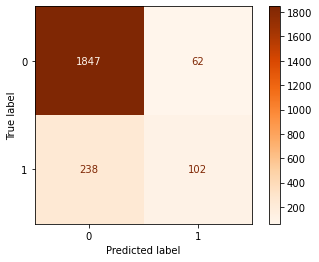

In [267]:
logreg = LogisticRegression(random_state=seed, max_iter = 1e4)

model = logreg.fit(X_train_scaled, y_train)
plot_confusion_matrix(model, X_train_scaled, y_train, cmap=plt.cm.Oranges)

In [268]:
cv = cross_validate(model, X_train_scaled, y_train, scoring=["accuracy", "recall"])

print(f"Average Accuracy: {cv['test_accuracy'].mean()} +/- {cv['test_accuracy'].std()}")
print(f"Average Recall: {cv['test_recall'].mean()} +/- {cv['test_recall'].std()}")

Average Accuracy: 0.8510398416233607 +/- 0.01165869081022027
Average Recall: 0.24705882352941178 +/- 0.05294117647058824


## Pipeline

In [269]:

X = df.drop(["churn"], axis = 1)
y= df["churn"]
seed = 42

#holds 10% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.25, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.1, random_state=seed)

In [270]:
X_train.shape

(2249, 23)

In [271]:
# organize columns for the pipeline
num_cols = []
ohe_cols = []

for c in X_train.columns:
    if X_train[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        ohe_cols.append(c)

In [272]:
print(num_cols)
print(ohe_cols)

['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'total_domestic_minutes', 'total_domestic_calls', 'total_domestic_charge', 'total_charge']
['state', 'international plan', 'voice mail plan', 'churn_rate']


In [273]:
nums = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

ohe = Pipeline(steps=[
    ("ohe_encoder", OneHotEncoder(handle_unknown="ignore"))
    ])


In [274]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", nums, num_cols),
        ("ohe", ohe, ohe_cols)
    ])

In [275]:
preprocess.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['account length', 'number vmail messages',
                                  'total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl charge',
                                  'customer service calls',
                                  'total_domestic_minutes',
                                  'total_domestic_calls',
                                  'total_domestic_charge', 'total_charge']),
                       

## Nearest Neighbors

In [276]:
knn = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', KNeighborsClassifier())
])

In [277]:
cross_validate(knn, X_train, y_train, return_train_score=True)

{'fit_time': array([0.03400183, 0.0280025 , 0.02700162, 0.03200245, 0.02700281]),
 'score_time': array([0.11901164, 0.12300897, 0.11100769, 0.11200857, 0.11100745]),
 'test_score': array([0.66222222, 0.66444444, 0.62666667, 0.67333333, 0.67706013]),
 'train_score': array([0.81878822, 0.81767649, 0.82045581, 0.81767649, 0.82166667])}

In [278]:
param_grid = {
    'classifier__n_neighbors': [5, 15, 25, 35, 45, 55, 65],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2, 10]
}

In [279]:
grid = GridSearchCV(knn, param_grid)

In [280]:
output = grid.fit(X_train, y_train)

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\neighbors\_base.py", line 466, in _fit
    raise ValueError("Metric '%s' not valid for sparse input. "
ValueError: Metric 'minkowski' not valid for sparse input. Use s

In [281]:
output.best_params_

{'classifier__n_neighbors': 65,
 'classifier__p': 1,
 'classifier__weights': 'distance'}

Training Scores:
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1-Score: 1.0
ROC-AUC: 1.0
**********
Testing Scores:
Test Accuracy: 0.716
Test Precision: 0.2839506172839506
Test Recall: 0.6388888888888888
Test F1-Score: 0.39316239316239315
ROC-AUC: 0.7440290758047767


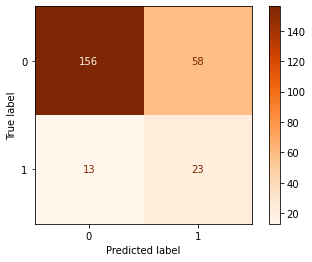

In [282]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

## Decision Tree No Tuning

In [283]:
dt = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [284]:
dt.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

In [285]:
y_preds = dt.predict(X_test)

Recall score for Model Before Tuning
0.7777777777777778
Confusion Matrix for Model Before Tuning


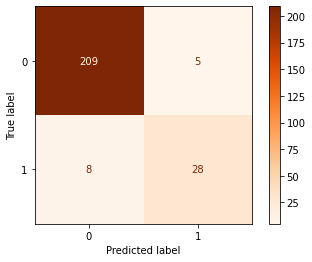

In [286]:
print('Recall score for Model Before Tuning')
print(recall_score(y_test, y_preds))
print('Confusion Matrix for Model Before Tuning')
plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Oranges)

In [287]:
cross_validate(dt, X_train, y_train, return_train_score=True)

{'fit_time': array([0.08900762, 0.08400559, 0.08600521, 0.08400607, 0.08700609]),
 'score_time': array([0.00800204, 0.00700116, 0.00800204, 0.00700235, 0.00700045]),
 'test_score': array([0.93555556, 0.94222222, 0.94222222, 0.93555556, 0.93095768]),
 'train_score': array([1., 1., 1., 1., 1.])}

## XGBoost

In [288]:
xgb = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', XGBClassifier(random_state=seed))
])

In [289]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

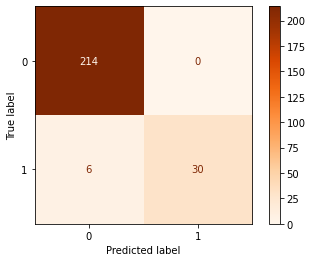

In [290]:
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Oranges)

In [291]:
y_preds = xgb.predict(X_test)

Recall score for Model Before Tuning
0.8333333333333334
Confusion Matrix for Model Before Tuning


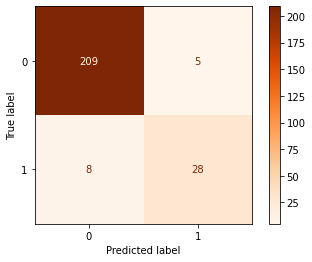

In [292]:
print('Recall score for Model Before Tuning')
print(recall_score(y_test, y_preds))
print('Confusion Matrix for Model Before Tuning')
plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Oranges)

In [293]:
cross_validate(xgb, X_train, y_train, return_train_score=True)

{'fit_time': array([0.29502559, 0.3020227 , 0.29502177, 0.31102228, 0.27801991]),
 'score_time': array([0.01700163, 0.01700139, 0.01700187, 0.01800394, 0.01700139]),
 'test_score': array([0.97333333, 0.98222222, 0.97777778, 0.98      , 0.97995546]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [294]:
xgb_grid = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', XGBClassifier(random_state=seed))
])

In [295]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [.1, .01, .001],
#     "classifier__early_stopping_rounds": [5],
    "classifier__max_depth": [2,3, 5]
}

In [296]:
grid = GridSearchCV(xgb_grid, param_grid)

In [297]:
output = grid.fit(X_train, y_train)

In [298]:
output.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 200}

Training Scores:
Train Accuracy: 0.9799911071587372
Train Precision: 1.0
Train Recall: 0.860248447204969
Train F1-Score: 0.9248747913188647
ROC-AUC: 0.9895373686127505
**********
Testing Scores:
Test Accuracy: 0.972
Test Precision: 1.0
Test Recall: 0.8055555555555556
Test F1-Score: 0.8923076923076924
ROC-AUC: 0.9287383177570094


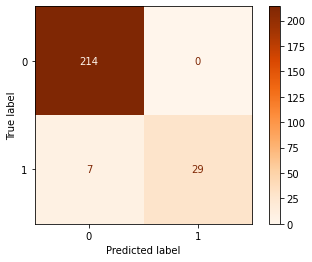

In [299]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

## Decision Tree with Tuning

In [300]:
dt_tuned = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(random_state=seed))
])

In [301]:
param_grid = {
    "classifier__max_depth": [5,7,10],
    "classifier__min_samples_split": [2,5,10],
    "classifier__min_samples_leaf": [2,5,10]
}

In [302]:
grid_dt = GridSearchCV(dt_tuned, param_grid)

In [303]:
output = grid_dt.fit(X_train, y_train)

In [304]:
output.best_params_

{'classifier__max_depth': 5,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2}

Training Scores:
Train Accuracy: 0.9764339706536238
Train Precision: 0.996309963099631
Train Recall: 0.8385093167701864
Train F1-Score: 0.9106239460370995
ROC-AUC: 0.9392814434950217
**********
Testing Scores:
Test Accuracy: 0.968
Test Precision: 0.9666666666666667
Test Recall: 0.8055555555555556
Test F1-Score: 0.8787878787878789
ROC-AUC: 0.9069963655244029


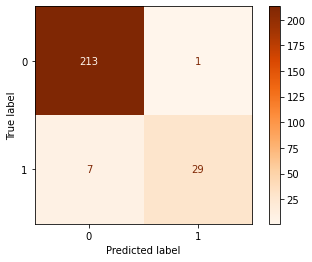

In [305]:
evaluate(output.best_estimator_, X_train, X_test, y_train, y_test, roc_auc='proba')

## Final Model

In [306]:

X = df.drop(["churn"],axis = 1)
y= df["churn"]
seed = 42

#holds 25% of my data for final evaluation.
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=seed)

#uses the remaining data and splits the data into test and train data to use while finding best model.
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.2, random_state=seed)

In [307]:
dt["preprocess"]

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['account length', 'number vmail messages',
                                  'total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl charge',
                                  'customer service calls',
                                  'total_domestic_minutes',
                                  'total_domestic_calls',
                                  'total_domestic_charge', 'total_charge']),
                       

In [308]:
X_train.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,total_domestic_minutes,total_domestic_calls,total_domestic_charge,total_charge,churn_rate
1941,VA,145,no,no,0,199.2,124,33.86,126.0,86,...,13.01,7.6,3,2.05,1,614.4,345,57.58,59.63,low
770,MN,179,no,no,0,170.7,54,29.02,191.1,108,...,9.66,13.3,4,3.59,1,576.4,269,54.92,58.51,med
40,GA,98,no,no,0,126.3,102,21.47,166.8,85,...,8.45,9.4,2,2.54,3,480.9,322,44.10,46.64,med-low
1303,VA,10,no,no,0,222.2,127,37.77,153.1,125,...,10.23,12.9,4,3.48,1,602.7,332,61.01,64.49,low
205,MO,66,no,yes,36,106.7,76,18.14,209.8,77,...,8.57,12.1,2,3.27,1,506.9,270,44.54,47.81,med-low


In [309]:
dt_final = Pipeline(steps=[
    ('preprocess', preprocess),
    ("sampling", SMOTE(random_state=seed)),
    ('classifier', DecisionTreeClassifier(max_depth = 5,
                                          min_samples_split=2,
                                          min_samples_leaf=2,
                                          random_state=seed))
])
dt_final.fit(X_use, y_use)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
                                                   'total night minutes',
                                                   'total night calls',
         

Training Scores:
Train Accuracy: 0.9759919973324441
Train Precision: 0.9917355371900827
Train Recall: 0.8391608391608392
Train F1-Score: 0.9090909090909092
ROC-AUC: 0.9367200697509672
**********
Testing Scores:
Test Accuracy: 0.9730538922155688
Test Precision: 1.0
Test Recall: 0.8333333333333334
Test F1-Score: 0.9090909090909091
ROC-AUC: 0.9193755288081007


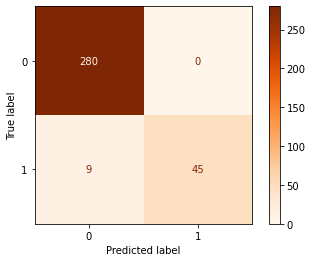

In [310]:
evaluate(output.best_estimator_, X_use, X_hold, y_use, y_hold, roc_auc='proba')

In [311]:
dt_final["preprocess"].fit_transform(X_train).shape

(2399, 78)

In [312]:
pd.DataFrame(dt_final["preprocess"].fit_transform(X_train)).head()

,0
0,"(0, 0)\t145.0\n (0, 2)\t199.2\n (0, 3)\t12..."
1,"(0, 0)\t179.0\n (0, 2)\t170.7\n (0, 3)\t54..."
2,"(0, 0)\t98.0\n (0, 2)\t126.3\n (0, 3)\t102..."
3,"(0, 0)\t10.0\n (0, 2)\t222.2\n (0, 3)\t127..."
4,"(0, 0)\t66.0\n (0, 1)\t36.0\n (0, 2)\t106...."


In [313]:
dt_final['classifier'].feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.00043856,
       0.00158743, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0004478 , 0.02384175, 0.03858705, 0.21093487,
       0.        , 0.        , 0.        , 0.33613922, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00368791, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.28320127, 0.00507589, 0.        , 0.04265221, 0.05340

In [314]:
num_cols_final = dt_final['preprocess'].transformers_[0][2]
num_cols_final

['account length',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'total_domestic_minutes',
 'total_domestic_calls',
 'total_domestic_charge',
 'total_charge']

In [315]:
ohe_cols_transformed = dt_final['preprocess'].transformers_[1][1]['ohe_encoder'].get_feature_names(ohe_cols)
ohe_cols_transformed

array(['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV',
       'state_WY', 'international plan_no', 'international plan_yes',
       'voice mail plan_no', 'voice mail plan_yes', 'churn_rate_high',
       'churn_rate_low', 'churn_rate_med', 'churn_rate_med-low'],
      dtype=object)

In [316]:
final_cols =[*num_cols_final, *ohe_cols_transformed]
final_cols

['account length',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'total_domestic_minutes',
 'total_domestic_calls',
 'total_domestic_charge',
 'total_charge',
 'state_AK',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',


In [317]:
features = pd.DataFrame.from_dict(dict(zip(final_cols, dt_final['classifier'].feature_importances_)), 
                       orient='index').sort_values(by=0, ascending=False).head(10).reset_index()
features

,index,0
0,total_charge,0.336139
1,international plan_no,0.283201
2,customer service calls,0.210935
3,churn_rate_high,0.053406
4,voice mail plan_yes,0.042652
5,total intl charge,0.038587
6,total intl calls,0.023842
7,international plan_yes,0.005076
8,state_LA,0.003688
9,total eve minutes,0.001587


In [318]:
n_nodes = dt_final["classifier"].tree_.node_count
children_left = dt_final["classifier"].tree_.children_left
children_right = dt_final["classifier"].tree_.children_right
feature = dt_final["classifier"].tree_.feature
threshold = dt_final["classifier"].tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 33 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 18] <= 74.05419921875 else to node 22.
	node=1 is a split node: go to node 2 if X[:, 70] <= 0.9999057948589325 else to node 9.
		node=2 is a split node: go to node 3 if X[:, 70] <= 0.0011587738990783691 else to node 8.
			node=3 is a split node: go to node 4 if X[:, 12] <= 2.988521695137024 else to node 5.
				node=4 is a leaf node.
				node=5 is a split node: go to node 6 if X[:, 13] <= 3.482963442802429 else to node 7.
					node=6 is a leaf node.
					node=7 is a leaf node.
			node=8 is a leaf node.
		node=9 is a split node: go to node 10 if X[:, 14] <= 3.0163464546203613 else to node 17.
			node=10 is a split node: go to node 11 if X[:, 74] <= 0.0010519216302782297 else to node 14.
				node=11 is a split node: go to node 12 if X[:, 37] <= 0.009047150611877441 else to node 13.
					node=12 is a leaf node.
					node=13 is a leaf node.
				node=14 is a split node: 

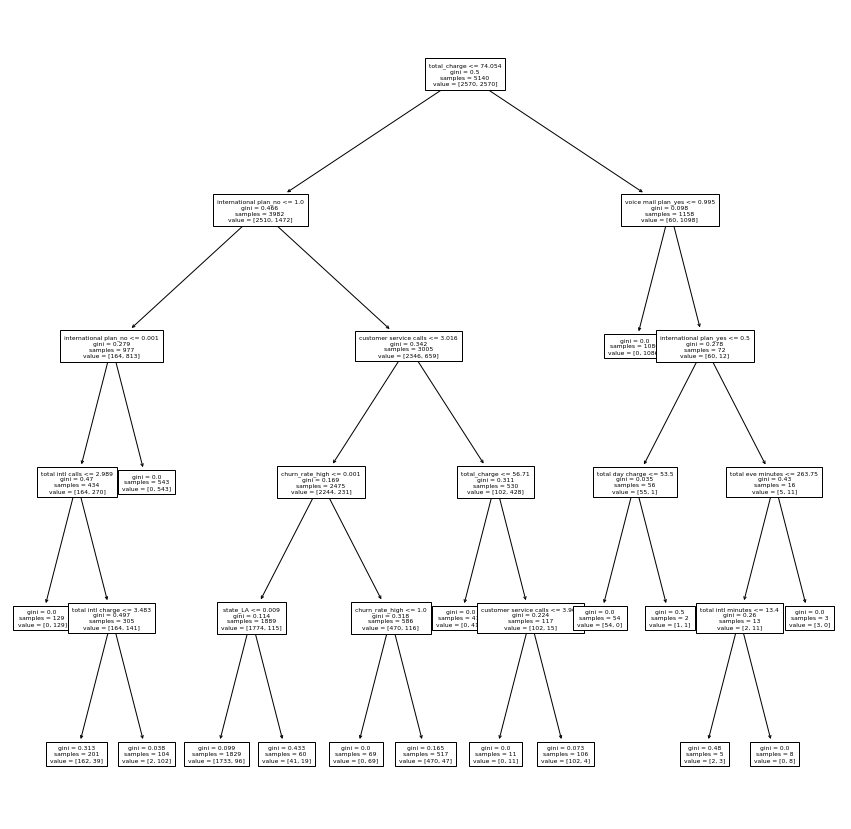

In [319]:
fig, ax = plt.subplots(figsize=(15,15))
plot_tree(dt_final["classifier"], feature_names=final_cols, fontsize=6)
plt.show()